---
title: "Image Recognition with a Convolutional Neural Network"
date: "2018-05-05"
path: "/image-recognition-with-a-convolutional-neural-network/"
category: "Projects"
thumbnail: "thumbnail.jpg"
---

In this write up I will be developing a Convolutional Neural Network to do image recognition. The hypothetical client has given me a repository of images and they ask if I can build a model that will correctly recognize what's in the images. My assumption here is that this can be predicted, and that there is sufficient data to make this prediction:

_Hypothesis 1:_
 - There is a statistical probability relating the outputs to the inputs (I can beat random).
 
_Hypothesis 2:_
 - There is sufficient data to learn the relationships between the inputs and the outputs.
 
To test this, I will take a quick look at the data, build a base line model, and see if I can apply training tricks, statistical techniques and architectures in the hopes that I will have a powerful prediction engine.

In [1]:
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Load dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Peek at some samples

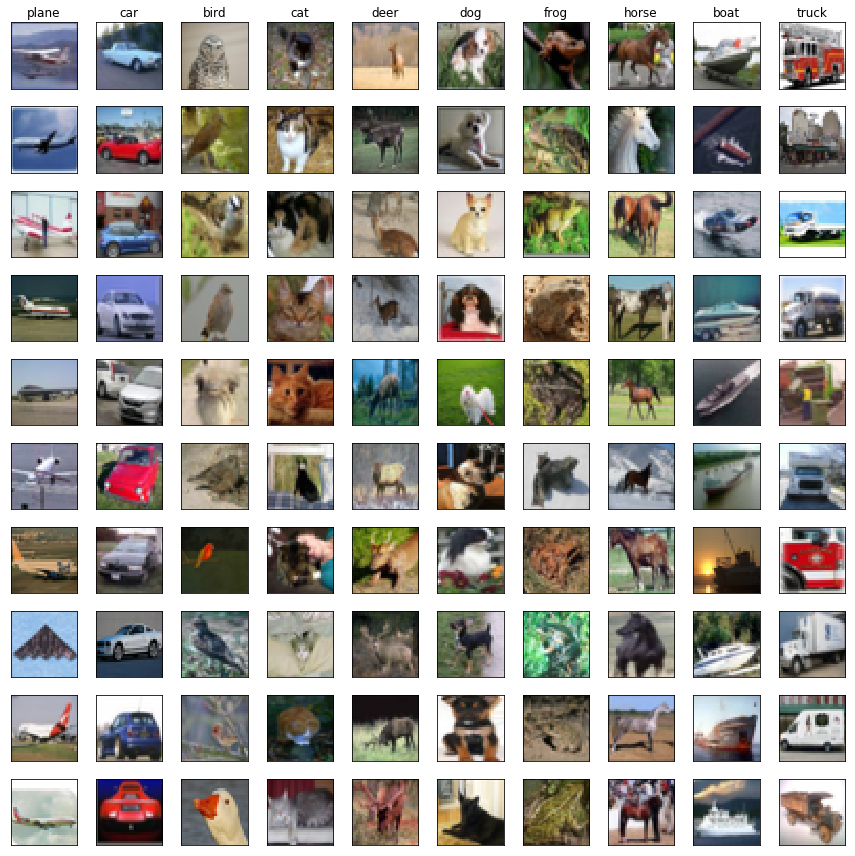

In [5]:
label = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

rows, cols = 10, 10
def plot_samples(x_train, y_train, rows, cols):
    
    fig = plt.figure(figsize=(12,12))
    g_s = gridspec.GridSpec(rows, cols)
    # g_s.update(left=0.1,right=0.9,wspace=0.05, top=0.9, bottom=0.1)
    ax = {}
    
    for i in range(cols):
        sample_pics = x_train[(y_train == i).reshape(-1)]
        for j in range(rows):
            num_samples = sample_pics.shape[0]
            random_idx = np.random.choice(num_samples, replace=False) 
            sample_pic = x_train[(y_train == i).reshape(-1)][random_idx]

            ax[(i, j)] = fig.add_subplot(g_s[j, i])
            ax[(i, j)].set_xticks([])
            ax[(i, j)].set_yticks([])
            ax[(i, j)].imshow(sample_pic)
        ax[(i, 0)].set_title(label[i])
    fig.tight_layout()
plot_samples(x_train, y_train, rows, cols);

### Observations
- Some images are not completely centered (padding and sub-sampling might help)
- Background color is diverse within subgroups (model may not train on color scheme of photos?)
- The entire object is contained in each image (easier time for recognition)
- the images are all the same size (no cropping, padding or subsampling necessary)
- there is a perfect distribution of classes (oversampling not necessary)

### Splitting the data
First let's create a validation set from the training set. It's good practice to train your model on one set of data, then improve the accuracy and tune hyper-parameters by measuring against a validation set. After all the fine-tuning is done, the final predictive capabilities of the model should be on a set of data that it has never seen before. There is a possibility that in the process of tuning the hyper-parameters, the model has over-fitted to the validation data, so a good judge of generalization is to measure against the test dataset.

In [6]:
print('Current Data Shape:'
      '\n\tX(train): {}'
      '\n\tY(train): {}'
      '\n\tX(test): {}'
      '\n\tY(test): {}'.format(x_train.shape[0],
                               y_train.shape[0],
                               x_test.shape[0],
                               y_test.shape[0]))

def shuffle_split(x, y, split=0.8):
    samples = x.shape[0]
    shuffle = np.random.choice(samples, samples)
    x = x[shuffle]
    y = y[shuffle]
    split_idx = int(samples * split)
    x_train = x[:split_idx]
    y_train = y[:split_idx]
    x_valid = x[split_idx:]
    y_valid = y[split_idx:]
    
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = shuffle_split(x_train, y_train)

print('Split Data Shape:'
      '\n\tX(train): {}'
      '\n\tY(train): {}'
      '\n\tX(valid): {}'
      '\n\tY(valid): {}'.format(x_train.shape[0],
                               y_train.shape[0],
                               x_valid.shape[0],
                               y_valid.shape[0]))


Current Data Shape:
	X(train): 50000
	Y(train): 50000
	X(test): 10000
	Y(test): 10000
Split Data Shape:
	X(train): 40000
	Y(train): 40000
	X(valid): 10000
	Y(valid): 10000


### Pre-Processing the Data
Generally Machine Learning models like normalized data. That way no single feature over powers other features because of the magnitude of scale. Image data is technically of the same scale (all values exist between 0-255), but it's best to have the values centered about zero and with a standard deviation of 1. This helps control the weight values and generally allows the model to train properly.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# Data metadata
num_classes = 10
in_dim = x_train.shape[1:]

# Normalize data; create preprocessing function
data = ImageDataGenerator(samplewise_center=True, 
                          samplewise_std_normalization=True,
                          horizontal_flip=True)
data.fit(x_train)

# Convert y_train to one hot encoding of classes(num_examples x num_classes)
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

# TODO:
# Add Data Augmentation
# Add padding: Add pixels around image and pick 32x32 not centered crops

### Simple Deep Convolutional Neural Network

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout

# hyper parameters:
p = 0.25  # Dropout probability 
k = 3     # kernel size for convolution
f1 = 32   # number of filters, convolution 1
f2 = 64   # number of filters, convolution 2

model = Sequential(
        [Conv2D(f1, (k, k), padding='same', name='First-Convolution', input_shape=in_dim),
         Activation('relu', name='First-Relu'),
         Conv2D(f1, (k, k), padding='same', name='Second-Convolution'),
         Activation('relu', name='Second-Relu'),
         MaxPooling2D((2, 2), name='First-Max-Pool'),
         Dropout(p, name='First-Dropout'),
         Conv2D(f2, (k, k), padding='same', name='Third-Convolution'),
         Activation('relu', name='Third-Relu'),
         Conv2D(f2, (k, k), padding='same', name='Fourth-Convolution'),
         Activation('relu', name='Fourth-Relu'),
         MaxPooling2D((2, 2), name='Second-Max-Pool'),
         Dropout(p, name='Second-Dropout'),
         Flatten(name='Flatten'),
         Dense(512, name='First-Affine'),
         Activation('relu', name='Fifth-Relu'),
         Dropout(2*p, name='Third-Dropout'),
         Dense(10, name='Final-Connected-Layer'),
         Activation('softmax', name='Softmax')
        ])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First-Convolution (Conv2D)   (None, 32, 32, 32)        896       
_________________________________________________________________
First-Relu (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
Second-Convolution (Conv2D)  (None, 32, 32, 32)        9248      
_________________________________________________________________
Second-Relu (Activation)     (None, 32, 32, 32)        0         
_________________________________________________________________
First-Max-Pool (MaxPooling2D (None, 16, 16, 32)        0         
_________________________________________________________________
First-Dropout (Dropout)      (None, 16, 16, 32)        0         
_________________________________________________________________
Third-Convolution (Conv2D)   (None, 16, 16, 64)        18496     
__________

### Things to try:
- leaky relu
- Maxout (Goodfellow et al.)


### Model Architecture

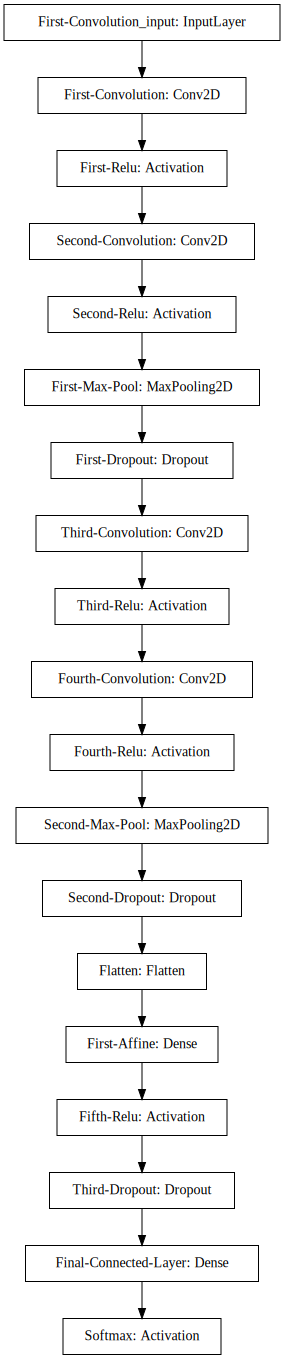

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Compile and Train a Base Model

In [13]:
from keras import optimizers
import keras.backend as K
import pickle

base_model = model

# Iterations
num_train = x_train.shape[0]
num_epochs = 300
batch_size = 500
iters_per_epoch = num_train // batch_size
cycle_step_size = iters_per_epoch * num_epochs  # recommended setting per ArXiv paper

base_model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.SGD(lr=0.001), 
                   metrics=['categorical_accuracy'])

# Flow training data through pre-processing pipeline
train_datagen = data.flow(x_train, y_train, batch_size=batch_size)
valid_datagen = data.flow(x_valid, y_valid, batch_size=batch_size)
test_datagen = data.flow(x_test, batch_size=batch_size)

# Fit the model
hist = base_model.fit_generator(train_datagen,
                                epochs=num_epochs,
                                validation_data=valid_datagen,
                                shuffle=True)

y_pred = base_model.predict_generator(test_datagen)

Epoch 1/300
80/80 [==============================] - 9s 108ms/step - loss: 2.3291 - categorical_accuracy: 0.1034 - val_loss: 2.2949 - val_categorical_accuracy: 0.1276
Epoch 2/300
80/80 [==============================] - 8s 102ms/step - loss: 2.3160 - categorical_accuracy: 0.1079 - val_loss: 2.2882 - val_categorical_accuracy: 0.1490
Epoch 3/300
80/80 [==============================] - 8s 103ms/step - loss: 2.3052 - categorical_accuracy: 0.1160 - val_loss: 2.2815 - val_categorical_accuracy: 0.1717
Epoch 4/300
80/80 [==============================] - 8s 102ms/step - loss: 2.2968 - categorical_accuracy: 0.1230 - val_loss: 2.2756 - val_categorical_accuracy: 0.1844
Epoch 5/300
80/80 [==============================] - 8s 103ms/step - loss: 2.2898 - categorical_accuracy: 0.1266 - val_loss: 2.2687 - val_categorical_accuracy: 0.1992
Epoch 6/300
80/80 [==============================] - 8s 103ms/step - loss: 2.2841 - categorical_accuracy: 0.1340 - val_loss: 2.2615 - val_categorical_accuracy: 0.217

Epoch 50/300
80/80 [==============================] - 8s 102ms/step - loss: 1.8555 - categorical_accuracy: 0.3294 - val_loss: 1.7668 - val_categorical_accuracy: 0.3883
Epoch 51/300
80/80 [==============================] - 8s 102ms/step - loss: 1.8535 - categorical_accuracy: 0.3285 - val_loss: 1.7606 - val_categorical_accuracy: 0.3891
Epoch 52/300
80/80 [==============================] - 8s 102ms/step - loss: 1.8414 - categorical_accuracy: 0.3383 - val_loss: 1.7545 - val_categorical_accuracy: 0.3901
Epoch 53/300
80/80 [==============================] - 8s 102ms/step - loss: 1.8398 - categorical_accuracy: 0.3356 - val_loss: 1.7511 - val_categorical_accuracy: 0.3930
Epoch 54/300
80/80 [==============================] - 8s 102ms/step - loss: 1.8345 - categorical_accuracy: 0.3373 - val_loss: 1.7445 - val_categorical_accuracy: 0.3935
Epoch 55/300
80/80 [==============================] - 8s 103ms/step - loss: 1.8278 - categorical_accuracy: 0.3424 - val_loss: 1.7384 - val_categorical_accuracy:

Epoch 99/300
80/80 [==============================] - 8s 103ms/step - loss: 1.6300 - categorical_accuracy: 0.4076 - val_loss: 1.5284 - val_categorical_accuracy: 0.4559
Epoch 100/300
80/80 [==============================] - 8s 103ms/step - loss: 1.6258 - categorical_accuracy: 0.4105 - val_loss: 1.5251 - val_categorical_accuracy: 0.4570
Epoch 101/300
80/80 [==============================] - 8s 103ms/step - loss: 1.6188 - categorical_accuracy: 0.4109 - val_loss: 1.5203 - val_categorical_accuracy: 0.4579
Epoch 102/300
80/80 [==============================] - 8s 100ms/step - loss: 1.6200 - categorical_accuracy: 0.4124 - val_loss: 1.5196 - val_categorical_accuracy: 0.4582
Epoch 103/300
80/80 [==============================] - 8s 102ms/step - loss: 1.6162 - categorical_accuracy: 0.4129 - val_loss: 1.5147 - val_categorical_accuracy: 0.4616
Epoch 104/300
80/80 [==============================] - 8s 104ms/step - loss: 1.6091 - categorical_accuracy: 0.4150 - val_loss: 1.5139 - val_categorical_accu

80/80 [==============================] - 8s 100ms/step - loss: 1.5181 - categorical_accuracy: 0.4496 - val_loss: 1.4242 - val_categorical_accuracy: 0.4921
Epoch 148/300
80/80 [==============================] - 8s 97ms/step - loss: 1.5178 - categorical_accuracy: 0.4474 - val_loss: 1.4225 - val_categorical_accuracy: 0.4920
Epoch 149/300
80/80 [==============================] - 8s 100ms/step - loss: 1.5169 - categorical_accuracy: 0.4494 - val_loss: 1.4200 - val_categorical_accuracy: 0.4949
Epoch 150/300
80/80 [==============================] - 8s 99ms/step - loss: 1.5124 - categorical_accuracy: 0.4497 - val_loss: 1.4208 - val_categorical_accuracy: 0.4924
Epoch 151/300
80/80 [==============================] - 8s 99ms/step - loss: 1.5103 - categorical_accuracy: 0.4527 - val_loss: 1.4158 - val_categorical_accuracy: 0.4941
Epoch 152/300
80/80 [==============================] - 8s 102ms/step - loss: 1.5084 - categorical_accuracy: 0.4523 - val_loss: 1.4150 - val_categorical_accuracy: 0.4962
Epo

80/80 [==============================] - 8s 101ms/step - loss: 1.4498 - categorical_accuracy: 0.4797 - val_loss: 1.3552 - val_categorical_accuracy: 0.5164
Epoch 196/300
80/80 [==============================] - 8s 101ms/step - loss: 1.4497 - categorical_accuracy: 0.4775 - val_loss: 1.3546 - val_categorical_accuracy: 0.5155
Epoch 197/300
80/80 [==============================] - 8s 103ms/step - loss: 1.4482 - categorical_accuracy: 0.4754 - val_loss: 1.3528 - val_categorical_accuracy: 0.5162
Epoch 198/300
80/80 [==============================] - 8s 103ms/step - loss: 1.4460 - categorical_accuracy: 0.4750 - val_loss: 1.3566 - val_categorical_accuracy: 0.5200
Epoch 199/300
80/80 [==============================] - 8s 102ms/step - loss: 1.4449 - categorical_accuracy: 0.4794 - val_loss: 1.3497 - val_categorical_accuracy: 0.5174
Epoch 200/300
80/80 [==============================] - 8s 101ms/step - loss: 1.4471 - categorical_accuracy: 0.4752 - val_loss: 1.3514 - val_categorical_accuracy: 0.5200


80/80 [==============================] - 8s 101ms/step - loss: 1.3948 - categorical_accuracy: 0.4959 - val_loss: 1.3007 - val_categorical_accuracy: 0.5382
Epoch 244/300
80/80 [==============================] - 8s 103ms/step - loss: 1.3972 - categorical_accuracy: 0.4962 - val_loss: 1.2986 - val_categorical_accuracy: 0.5363
Epoch 245/300
80/80 [==============================] - 8s 102ms/step - loss: 1.3885 - categorical_accuracy: 0.5005 - val_loss: 1.2975 - val_categorical_accuracy: 0.5395
Epoch 246/300
80/80 [==============================] - 8s 103ms/step - loss: 1.3918 - categorical_accuracy: 0.4998 - val_loss: 1.2971 - val_categorical_accuracy: 0.5408
Epoch 247/300
80/80 [==============================] - 8s 101ms/step - loss: 1.3885 - categorical_accuracy: 0.4995 - val_loss: 1.2959 - val_categorical_accuracy: 0.5398
Epoch 248/300
80/80 [==============================] - 8s 103ms/step - loss: 1.3887 - categorical_accuracy: 0.4981 - val_loss: 1.2955 - val_categorical_accuracy: 0.5382


80/80 [==============================] - 8s 102ms/step - loss: 1.3438 - categorical_accuracy: 0.5179 - val_loss: 1.2504 - val_categorical_accuracy: 0.5575
Epoch 292/300
80/80 [==============================] - 8s 102ms/step - loss: 1.3422 - categorical_accuracy: 0.5173 - val_loss: 1.2481 - val_categorical_accuracy: 0.5572
Epoch 293/300
80/80 [==============================] - 8s 102ms/step - loss: 1.3456 - categorical_accuracy: 0.5179 - val_loss: 1.2485 - val_categorical_accuracy: 0.5579
Epoch 294/300
80/80 [==============================] - 8s 101ms/step - loss: 1.3412 - categorical_accuracy: 0.5216 - val_loss: 1.2461 - val_categorical_accuracy: 0.5601
Epoch 295/300
80/80 [==============================] - 8s 104ms/step - loss: 1.3400 - categorical_accuracy: 0.5160 - val_loss: 1.2439 - val_categorical_accuracy: 0.5599
Epoch 296/300
80/80 [==============================] - 8s 101ms/step - loss: 1.3396 - categorical_accuracy: 0.5212 - val_loss: 1.2445 - val_categorical_accuracy: 0.5587


### Save Model
I'm going to save the model so when I revisit the algorithm development, I don't need to retrain a base model for comparison.

In [17]:
import pickle

# serialize model to JSON
model_json = model.to_json()
with open("base_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("base_model.h5")
print("Saved model to disk")

model.save('base_model_all.h5')

# pickle the history
with open('base_model_history.pickle', 'wb') as handle:
    pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saved model to disk


As you can see in the plot to the right, it is not too clear on where the valley is with the learning rate and loss value. Well, that's machine learning for you. In an update to this post I will do some troubleshooting and look over this further, but the best I can ascertain from the visualization as it stands is a good initial learning rate would be in the $10^{-3}$ range, as it looks like theres a dip right at the $10^{-2}$.

### Assess Training and Model Accuracy

In [20]:
import pickle
from keras.models import model_from_json

# Load Model
json_file = open('base_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
base_model = model_from_json(loaded_model_json)

# load weights into new model
base_model.load_weights("base_model.h5")
print("Loaded model from disk")

# Load history
with open('base_model_history.pickle', 'rb') as handle:
    history = pickle.load(handle)

Loaded model from disk


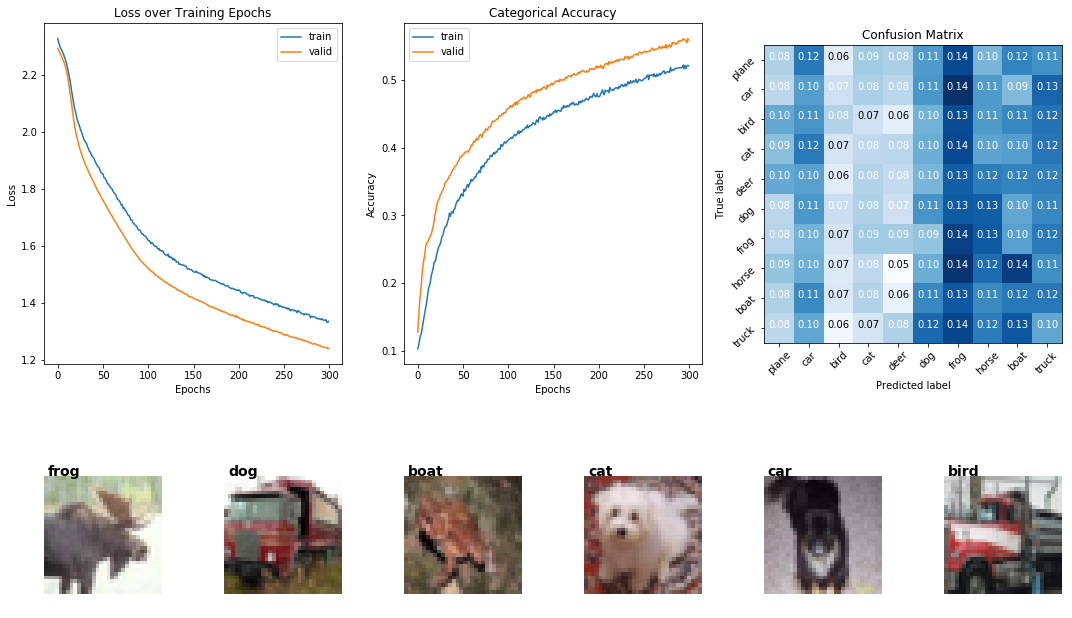

In [59]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    
def dashboard(history, cm, labels, y_pred=None, test_data=None):
    """
    Creates a dashboard of the data
    """
    assert len(y_pred.shape) == 1, "y_pred must be a 1D array of truth values"
    
    fig = plt.figure(figsize=(15,10))
    grid = gridspec.GridSpec(2, 6)
    
    ax = []
    
    ax += [fig.add_subplot(grid[0, :2])]
    ax[0].set_title('Loss over Training Epochs')
    ax[0].plot(history['loss'])
    ax[0].plot(history['val_loss'])
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'valid'])
    
    ax += [fig.add_subplot(grid[0, 2:4])]
    ax[1].set_title('Categorical Accuracy')
    ax[1].plot(history['categorical_accuracy'])
    ax[1].plot(history['val_categorical_accuracy'])
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['train', 'valid'])
    
    ax += [fig.add_subplot(grid[0, 4:6])]
    ax[2].set_title('Confusion Matrix')
    plot_confusion_matrix(cm, labels, ax=ax[2], normalize=True)
    
    grid.update(hspace=0)
    if not y_pred is None:
        x_test, y_test = test_data
        
        imgs = x_test[y_test != y_pred]
        lbls = y_test[y_test != y_pred]
        
        num_samples = len(lbls) if len(lbls) < 6 else 6
        
        # choose random images
        idxs = np.random.choice(imgs.shape[0], num_samples)
        for i in range(num_samples):
            ax += [fig.add_subplot(grid[1,i])]
            ax[3+i].imshow(x_test[idxs[i]])
            ax[3+i].text(s=labels[y_pred[i]], x=0.5, y=-0.5, weight='bold', size='14')
            ax[3+i].axis('off')
            
    fig.tight_layout()


labels = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

class_names = list(labels.values())

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
dashboard(history, cm=cnf_matrix, labels=class_names, y_pred=y_pred.argmax(1), test_data=(x_test, y_test.argmax(1)))

In [50]:
gridspec(grid, 3)

NameError: name 'grid' is not defined

### Deciding on the Best Learning Rate Intial Value
One technique talked about in Fast.ai was to plot an increasing learning rate value against the loss value to see what an ideal learning rate would be for a new architecture. To do this, after a batch of data is ran through the model, the loss is measured and recorded along with the learning rate. Then the learning rate is increased by a certain amount (in this case, we're looking at exponentially growing the learning rate). When plotted, there should be a minimum loss value for a range of learning rates used on the model. Right before this region is a good place to pick an initial learning rate for training a model.

### Technique: Cycling Learning Rate

One cool technique for optimizing the learning rate is the idea of cycling the learning rate values -- increasing the learning rate (instead of decaying it) as a means of helping the model hop out of local minimums and continue gradient descent to the best possible minima. Below is a callback implementation of the algorithm presented in the arXiv paper: https://arxiv.org/abs/1506.01186

### Using CLR to find optimal LR:
Next in this post, I will train the model without the learning rate scheduler (control group), then train it with the scheduler written above. I'll compare the loss and accuracy of the model against a validation set for these two learning methods to validate my hypothesis that cycling the learning rate is in fact an ideal method to employ. 

Epoch 1/1
2/2 [==============================] - 12s 6s/step - loss: 0.8653 - categorical_accuracy: 0.6920
Saved model to disk


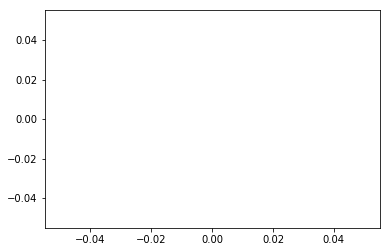

In [55]:
from CustomCallback import CyclicLR

# Learning Rate Scheduler
clr = CyclicLR(base_lr=0.0001, 
               max_lr=0.06, 
               step_size=cycle_step_size, 
               mode='triangular')

# Smooth out learning history
def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(clr.history['lr'][99:], moving_average(clr.history['loss'],100))

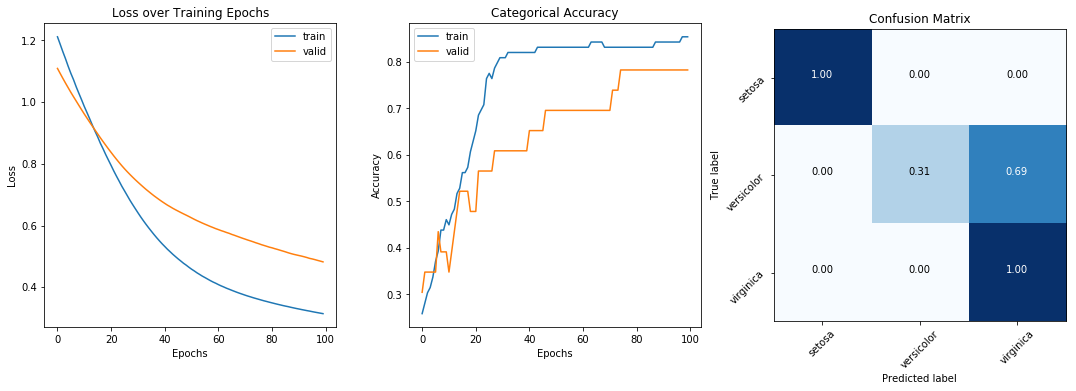

In [162]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.utils import to_categorical

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

# Scale Data
scalar = preprocessing.StandardScaler().fit(X_train)

# One Hot Encoding
Y_encode = to_categorical(Y_train)

# Model
classifier = Sequential(
                [
                    layers.Dense(16, input_dim=4, activation='relu'),
                    layers.Dense(3, activation='softmax', name='Final')
                ])

# Build
classifier.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=['categorical_accuracy'])

# Fit
hist = classifier.fit(scalar.transform(X_train), Y_encode, epochs=100, validation_split=0.2, verbose=0)

# Predict
y_pred = classifier.predict(scalar.transform(X_test))

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    
def dashboard(history, cm, labels, y_pred=None, test_data=None):
    """
    Creates a dashboard of the data
    """
    assert len(y.shape) == 1, "y_pred must be a 1D array of truth values"
    
    fig = plt.figure(figsize=(15,10))
    grid = gridspec.GridSpec(4, 9)
    
    ax = []
    
    ax += [fig.add_subplot(grid[:2, :3])]
    ax[0].set_title('Loss over Training Epochs')
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'valid'])
    
    ax += [fig.add_subplot(grid[0:2, 3:6])]
    ax[1].set_title('Categorical Accuracy')
    ax[1].plot(history.history['categorical_accuracy'])
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['train', 'valid'])
    
    ax += [fig.add_subplot(grid[0:2, 6:])]
    ax[2].set_title('Confusion Matrix')
    plot_confusion_matrix(cm, labels, ax=ax[2], normalize=True)
    
    if not y_pred is None:
        x_test, y_test = test_data
        
        imgs = x_test[y_test != y_pred]
        lbls = y_test[y_test != y_pred]
        
        num_samples = len(lbls) if len(lbls) < 10 else 10
        
        # choose random images
        idxs = np.random.choice(imgs.shape[0], num_samples)
        for i in range(num_samples):
            ax += [fig.add_subplot(grid[3:,i])]
            ax[4+i].imshow(x_test[idsx[i]])
            ax[4+1].text(labels[y_pred[i]])
            
    fig.tight_layout()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_pred.argmax(1))
dashboard(hist, cm=cnf_matrix, labels=iris.target_names)


In [151]:
len(y_pred.argmax(1).shape)

1

In [104]:
uniques, ids = np.unique(y_pred, return_inverse=True)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [125]:
hist.history.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])

In [45]:
gridspec.SubplotSpec(grid)

NameError: name 'grid' is not defined